In [ ]:
# CREMA-D

In [165]:
import os
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

cwd = os.getcwd() 
audio_path = os.path.join(cwd, "AudioWAV")
audio_wav = [f for f in os.listdir(audio_path) if f.lower().endswith('.wav')]
# Emotions (Anger, Disgust, Fear, Happy, Neutral, and Sad)

print("Done")


Done


In [188]:
MAX_LEN = 174 # the length of the audio

X = []
y = []

for wav_files in audio_wav:
    # waveform is audio time series (Amplitude over time)
    # sr is sampling rate, number of samples per sec (Hz)

    # The path to the audio
    path = os.path.join(audio_path, wav_files)
    
    emotion_code = wav_files.split("_")[2]
    waveform, sr = librosa.load(path, sr = 22050)

    # Converting to mel_spec
    mel_spec = librosa.feature.melspectrogram(y = waveform, sr = sr, n_mels = 128)
    log_mel_spec = librosa.power_to_db(mel_spec, ref = np.max)
    
    # Padding and truncating 
    if log_mel_spec.shape[1] < MAX_LEN:
        # Pad shorter spectrograms with silence (the minimum value)
        pad_width = MAX_LEN - log_mel_spec.shape[1]
        log_mel_spec = np.pad(log_mel_spec, pad_width=((0, 0), (0, pad_width)), mode = 'constant')
    else:
        # Truncate longer spectrograms
        log_mel_spec = log_mel_spec[:, :MAX_LEN]

        
    log_mel_spec = log_mel_spec[..., np.newaxis] # Adding a channel


    # Appending into X y, 
    X.append(log_mel_spec)
    y.append(emotion_code)    

print("Done")


Done


In [167]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import train_test_split # Splitting 70/30 


In [189]:

# We have X and y time to split it in 70/30

# Encoding into 0,1,2,3,4,5
y_encoded = LabelEncoder().fit_transform(y)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_encoded,
    test_size = 0.3, # 30% is to test it
    stratify = y_encoded,
    random_state = 1
)

X_train = np.array(X_train)
X_val = np.array(X_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

# Normalizing
min_val = np.min(X_train)
max_val = np.max(X_train)
X_train = (X_train - min_val) / (max_val - min_val)
X_val = (X_val - min_val) / (max_val - min_val)

print("Done")


Done


In [190]:
# Defining the model

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape = (128, MAX_LEN, 1))) # Use MAX_LEN
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25)) # Add Dropout

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.25)) # Add Dropout

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(Dropout(0.5)) # Add a larger Dropout before the final layer

model.add(layers.Dense(6, activation='softmax')) # Using softmax is often more stable

print("Done")


Done


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [203]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)              │ (None, 126, 172, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 63, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 63, 86, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 61, 84, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 30, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 42, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 28, 40, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 71680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │     4,587,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,643,718 (17.71 MB)

 Trainable params: 4,643,718 (17.71 MB)

 Non-trainable params: 0 (0.00 B)

In [204]:

model.compile(optimizer = 'adam', 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

# Training the model

history = model.fit(
    X_train, y_train,
    epochs = 50, 
    validation_data = (X_val, y_val),
    verbose = 1 
)

print("Done")



Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 67s 205ms/step - accuracy: 0.2491 - loss: 1.7629 - val_accuracy: 0.3988 - val_loss: 1.5277
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 101s 310ms/step - accuracy: 0.3660 - loss: 1.5337 - val_accuracy: 0.4053 - val_loss: 1.4766
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 95s 291ms/step - accuracy: 0.3936 - loss: 1.4872 - val_accuracy: 0.4216 - val_loss: 1.4183
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 85s 260ms/step - accuracy: 0.4130 - loss: 1.4310 - val_accuracy: 0.4570 - val_loss: 1.3692
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 87s 268ms/step - accuracy: 0.4440 - loss: 1.3800 - val_accuracy: 0.4807 - val_loss: 1.3388
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 87s 267ms/step - accuracy: 0.4749 - loss: 1.3098 - val_accuracy: 0.4610 - val_loss: 1.3548
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 101s 310ms/step - accuracy: 0.4879 - loss: 1.2594 - val_accuracy: 0.5231 - val_loss: 1.2364
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 90s 276ms/step - accuracy: 0.5167 - loss:

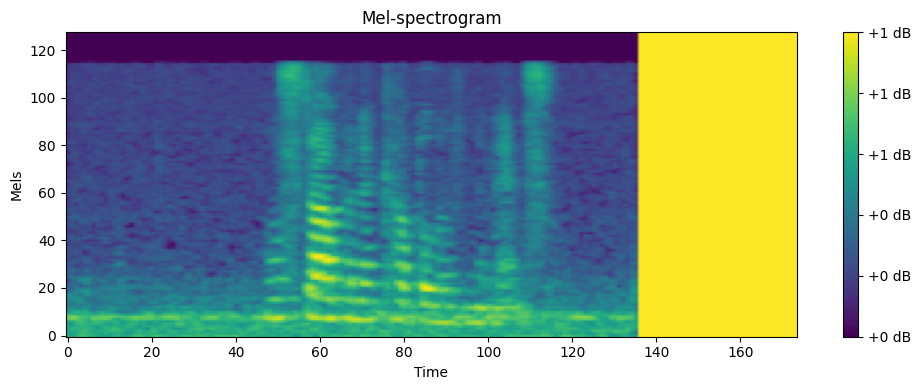

In [202]:
# A graph of the Mel-spectrogram
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.imshow(X_train[101].squeeze(), cmap = 'viridis', origin = 'lower', aspect = 'auto')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-spectrogram')
plt.xlabel('Time')
plt.ylabel('Mels')
plt.tight_layout()
plt.show()

In [227]:
# Saving model

model.save('emotion_classifier_model.keras')

In [226]:
from tensorflow.keras.models import load_model

# This is used if wanting to load the model and start from before
model = load_model('emotion_classifier_model.keras')


previous_epochs = 50 # Previous is saved at 50
total_epochs = 52 # Add another 10 training if wanted
history = model.fit(
    X_train, y_train,
    epochs= total_epochs,  # More Training
    validation_data = (X_val, y_val),
    initial_epoch = previous_epochs
)



Epoch 51/52
326/326 ━━━━━━━━━━━━━━━━━━━━ 49s 150ms/step - accuracy: 0.8487 - loss: 0.3540 - val_accuracy: 0.8072 - val_loss: 1.1481
Epoch 52/52
326/326 ━━━━━━━━━━━━━━━━━━━━ 53s 163ms/step - accuracy: 0.8449 - loss: 0.3574 - val_accuracy: 0.8072 - val_loss: 1.1500


In [232]:
from tensorflow.keras import optimizers

# 1. Load the model
model = load_model('best_emotion_classifier_model.keras')

# Fine tuning
fine_tuning = optimizers.Adam(learning_rate = 0.00001) 

model.compile(optimizer = fine_tuning,
              loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

previous_epochs = 60
total_epochs = 63
history = model.fit(
    X_train, y_train,
    epochs = total_epochs,  
    validation_data = (X_val, y_val),
    initial_epoch = previous_epochs
)



Epoch 61/63
326/326 ━━━━━━━━━━━━━━━━━━━━ 63s 190ms/step - accuracy: 0.8465 - loss: 0.3514 - val_accuracy: 0.8088 - val_loss: 1.1528
Epoch 62/63
326/326 ━━━━━━━━━━━━━━━━━━━━ 81s 247ms/step - accuracy: 0.8448 - loss: 0.3527 - val_accuracy: 0.8088 - val_loss: 1.1525
Epoch 63/63
326/326 ━━━━━━━━━━━━━━━━━━━━ 109s 335ms/step - accuracy: 0.8475 - loss: 0.3499 - val_accuracy: 0.8088 - val_loss: 1.1537


In [231]:

# Testing validation
model = load_model('best_emotion_classifier_model.keras')

val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose = 0)

print(f"The loaded model's accuracy on the unseen data is: {val_accuracy * 100:.2f}%")

The loaded model's accuracy on the unseen data is: 80.86%


In [236]:
# Assuming 'y' is your list of original labels and 'y_encoded' is the array from LabelEncoder

# Create a dictionary to store the mapping
label_mapping = {}

# Zip the two lists together and add the pairs to the dictionary
for label, encoded_label in zip(y, y_encoded):
  if encoded_label not in label_mapping:
    label_mapping[encoded_label] = label

# Print the mapping in a sorted, readable way
print("Emotion Label Mapping:")
for encoded_label, label in sorted(label_mapping.items()):
  print(f"{encoded_label}: {label}")

Emotion Label Mapping:
0: ANG
1: DIS
2: FEA
3: HAP
4: NEU
5: SAD
